## Dunn & Koo Figure 4

In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import h5py
import conutils
import random
from six.moves import cPickle
import seaborn as sns
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score

%matplotlib inline
%load_ext autoreload
%autoreload

# Figure 4a

Full PR curves for each of the original models (i.e. without incrporating multivariate partial correlations), along with models that do incorporate partial correlation

In [2]:
# Load validation data
#
ndata = 1000000

filename = '../valideval_dataset_unscattered.hdf5'
group_name = ['validation_data']
dataset = h5py.File(filename,'r')
%time vs_valid = np.array(dataset['/'+group_name[0]+'/vs_valid'])
label_valid = np.array(dataset['/'+group_name[0]+'/label_valid'])
true_lbl = np.reshape(label_valid,(ndata,))

CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 11.5 ms


In [3]:
filename = '../../Tensor/kaggle_connect_data/highconlowcon_dataset.hdf5'
group_name = ['normal_data']
dataset = h5py.File(filename,'r')
scores_H = np.array(dataset['/'+group_name[0]+'/scores_H'])
scores_L = np.array(dataset['/'+group_name[0]+'/scores_L'])
true_lbl_H = np.reshape(scores_H,(ndata,))
true_lbl_L = np.reshape(scores_L,(ndata,))

In [24]:
# Load in all analyses for all models and validation datasets
#
path = '../results/pickles/'
files = os.listdir(path)
pc_files = [f for f in files if 'crossval' in f and 'partialcorr' in f]
hc_files = [f for f in files if 'highcon' in f and 'partialcorr' in f]
lc_files = [f for f in files if 'lowcon' in f and 'partialcorr' in f]
hc_files_nopc = [f for f in files if 'highcon' in f and not 'partialcorr' in f]
lc_files_nopc = [f for f in files if 'lowcon' in f and not 'partialcorr' in f]
files = [f for f in files if 'crossval' in f and not 'partialcorr' in f]

In [7]:
# For plotting our own partial correlation metric, let's load in the validation data (F_4), and unscatter
#
filename = '../../Tensor/kaggle_connect_data/normal_dataset.hdf5'
group_name = ['normal_data']
dataset = h5py.File(filename,'r')
F_4 = np.array(dataset['/'+group_name[0]+'/F_4'])

pos = '../../Tensor/kaggle_connect_data/normal-4/networkPositions_normal-4.txt'
pos_4 = np.loadtxt(pos,delimiter=',')
F_4ls = conutils.unscatter(F_4.T,pos_4)

%time pred_out_4 = conutils.get_partial_corr_scores(F_4ls)

pred_out_4 = np.reshape(pred_out_4,(ndata,))

CPU times: user 1min 45s, sys: 9.91 s, total: 1min 55s
Wall time: 1min 20s


In [8]:
# For plotting our own partial correlation metric, let's load in the dense and sparse data, and unscatter
#
filename = '../../Tensor/kaggle_connect_data/highconlowcon_dataset.hdf5'
group_name = ['normal_data']
dataset = h5py.File(filename,'r')
F_H = np.array(dataset['/'+group_name[0]+'/F_H'])
F_L = np.array(dataset['/'+group_name[0]+'/F_L'])

pos = '../../Tensor/kaggle_connect_data/highcon/networkPositions_highcon.txt'
pos_H = np.loadtxt(pos,delimiter=',')
F_Hls = conutils.unscatter(F_H.T,pos_H)

pos = '../../Tensor/kaggle_connect_data/lowcon/networkPositions_lowcon.txt'
pos_L = np.loadtxt(pos,delimiter=',')
F_Lls = conutils.unscatter(F_L.T,pos_L)

In [9]:
%time pred_out_H = conutils.get_partial_corr_scores(F_Hls)
%time pred_out_L = conutils.get_partial_corr_scores(F_Lls)

pred_out_H = np.reshape(pred_out_H,(ndata,))
pred_out_L = np.reshape(pred_out_L,(ndata,))

CPU times: user 1min 22s, sys: 7.08 s, total: 1min 29s
Wall time: 56.6 s
CPU times: user 1min 18s, sys: 6.28 s, total: 1min 25s
Wall time: 54 s


In [10]:
def collate_predictions(fname, w=[1], ndata=1000000):
    """
    Reads in model predctions from each file given in fname, collapses them into an ensemble-averaged set of predictions
    
    inputs---
        fname: list of strings, file names
        w: optional weight array, defaults to equal weighting
        ndata: size of prediction array
    outputs--
        pred_all: 1d numpy array of predictions
    """
    
    pred_all = np.zeros((ndata,))
    
    if len(w) == 1 and w[0]==1:
        w = np.ones((len(fname),))/len(fname)
    
    for i in range(len(fname)):
        file = fname[i]
        savefile = os.path.join(path, file)
        f = open(savefile, 'rb')
        pred_lbl = cPickle.load(f)
        pred_all += pred_lbl*w[i]
        f.close()
        
    return pred_all

In [26]:
# Load in model weights optimized for enhancing early part of PR curve:
#
savefile = '../bestweights_crossval.pickle'
f = open(savefile,'rb')
w = cPickle.load(f)
f.close()

In [27]:
w4 = [1, 0, 1, 1, 1, 1, 1, 1] #only include models using the "standard" architecture

In [28]:
# Load in data, evaluate predictions for all models (RCNN, RCNN+PC, RCNN+PC opt, RCNN+PC standard, PC) on three datasets:
# validation (network 4), high connectivity, and low connectivity
#
pred_all = np.zeros(true_lbl.shape)
for i in range(len(files)):
    file = files[i]
    savefile = os.path.join(path, file)
    f = open(savefile, 'rb')
    pred_lbl = cPickle.load(f)
    pred_all += pred_lbl
    f.close()

pred_all_RCNN_val = pred_all/len(np.r_[1:3,4:7])

pred_all_RCNN_hc = collate_predictions(hc_files_nopc)

pred_all_RCNN_lc = collate_predictions(lc_files_nopc)

pred_all_RCNNPC_val = collate_predictions(pc_files)

pred_all_RCNNPC_hc = collate_predictions(hc_files)

pred_all_RCNNPC_lc = collate_predictions(lc_files)

pred_all_RCNNPCopt_val = collate_predictions(pc_files,w)

pred_all_RCNNPCopt_hc = collate_predictions(hc_files,w)

pred_all_RCNNPCopt_lc = collate_predictions(lc_files,w)

pred_all_RCNNPCstand_val = collate_predictions(pc_files,w4)

pred_all_RCNNPCstand_hc = collate_predictions(hc_files,w4)

pred_all_RCNNPCstand_lc = collate_predictions(lc_files,w4)

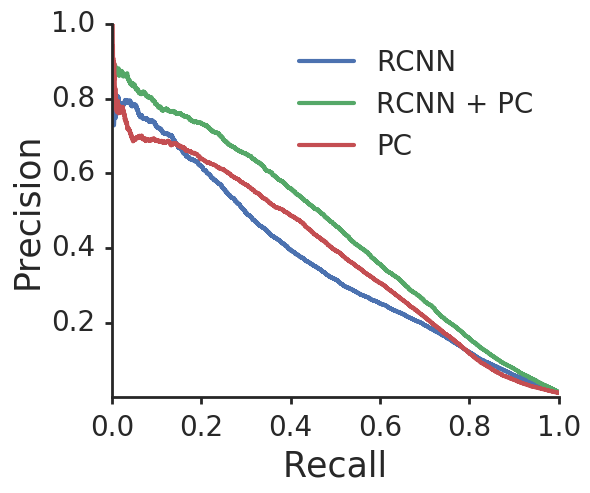

In [20]:
# Plot full PR curves

sns.set_style("white", {"xtick.major.size": "5", "ytick.major.size": "5",'axes.linewidth': 2})

fig, ax = plt.subplots(figsize=(6,5))

p, r, thresholds = precision_recall_curve(true_lbl, pred_all_RCNN_val)
ax.plot(r,p,linewidth=3,label='RCNN')

p, r, thresholds = precision_recall_curve(true_lbl, pred_all_RCNNPC_val)
ax.plot(r,p,linewidth=3,label='RCNN + PC')

p, r, thresholds = precision_recall_curve(true_lbl, pred_out_4)
ax.plot(r,p,linewidth=3,label='PC')

plt.ylim([1e-4, 1])
plt.ylabel('Precision',size=25)
plt.xlabel('Recall',size=25)
ax = plt.gca()
ax.tick_params(width=2,labelsize=20)
plt.tight_layout()
sns.despine()

plt.legend(loc=1,fontsize=20)
plt.savefig('./figure4a.pdf')

# Figure 4b

Zoomed in PR curves for each of the original models (i.e. without incrporating multivariate partial correlations), along with models that do incorporate partial correlation

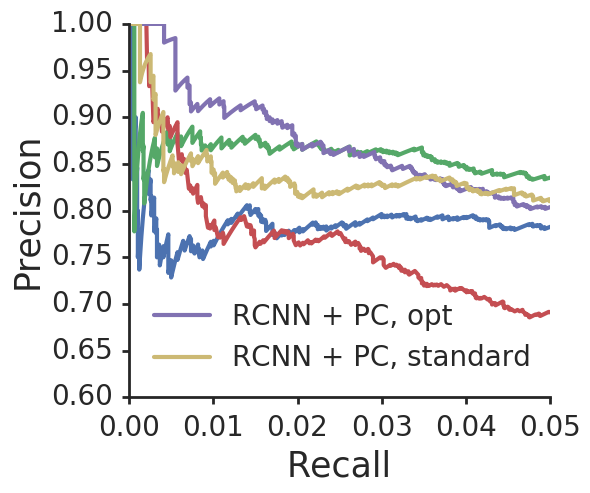

In [29]:
sns.set_style("white", {"xtick.major.size": "5", "ytick.major.size": "5",'axes.linewidth': 2})

fig, ax = plt.subplots(figsize=(6,5))

p, r, thresholds = precision_recall_curve(true_lbl, pred_all_RCNN_val)
ax.plot(r,p,linewidth=3)

p, r, thresholds = precision_recall_curve(true_lbl, pred_all_RCNNPC_val)
ax.plot(r,p,linewidth=3)

p, r, thresholds = precision_recall_curve(true_lbl, pred_out_4)
ax.plot(r,p,linewidth=3)

p, r, thresholds = precision_recall_curve(true_lbl, pred_all_RCNNPCopt_val)
ax.plot(r,p,linewidth=3,label='RCNN + PC, opt')

p, r, thresholds = precision_recall_curve(true_lbl, pred_all_RCNNPCstand_val)
ax.plot(r,p,linewidth=3,label='RCNN + PC, standard')

plt.ylim([1e-4, 1])
plt.ylabel('Precision',size=25)
plt.xlabel('Recall',size=25)
ax = plt.gca()
ax.tick_params(width=2,labelsize=20)
sns.despine()

plt.ylim([0.6, 1])
plt.xlim([0, 0.05])

plt.legend(loc=3,fontsize=20)
plt.tight_layout()
plt.savefig('./figure4b.pdf')

# Figure 4c

Generalization of the net. Plot PR curves for high connectivity and low connectivity network variants

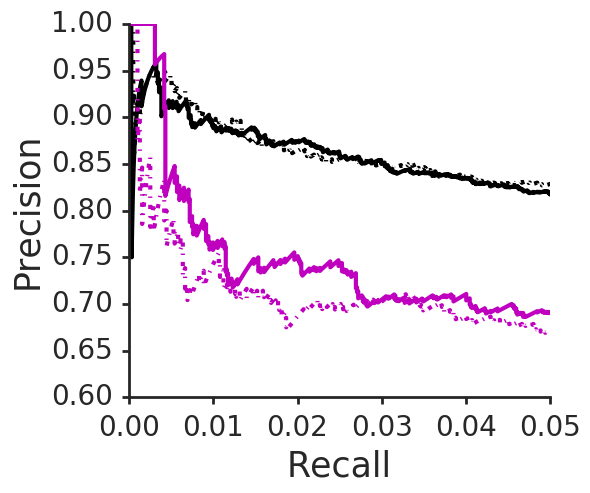

In [31]:
sns.set_style("white", {"xtick.major.size": "5", "ytick.major.size": "5",'axes.linewidth': 2})

fig, ax = plt.subplots(figsize=(6,5))

p, r, thresholds = precision_recall_curve(true_lbl_H, pred_all_RCNNPC_hc)
ax.plot(r,p,'k',linewidth=3)

p, r, thresholds = precision_recall_curve(true_lbl_H, pred_all_RCNNPCstand_hc)
ax.plot(r,p,'-.k',linewidth=3)

p, r, thresholds = precision_recall_curve(true_lbl_L, pred_all_RCNNPC_lc)
ax.plot(r,p,'m',linewidth=3)

p, r, thresholds = precision_recall_curve(true_lbl_L, pred_all_RCNNPCstand_lc)
ax.plot(r,p,'-.m',linewidth=3)

plt.ylim([1e-4, 1])
plt.ylabel('Precision',size=25)
plt.xlabel('Recall',size=25)
ax = plt.gca()
ax.tick_params(width=2,labelsize=20)

sns.despine()

plt.ylim([0.6, 1])
plt.xlim([0, 0.05])

plt.tight_layout()
plt.savefig('./figure4c.pdf')

# Figure 5b

Generalization of the net. Plot the Precision and Recall of different metrics on different networks at a threshold set based on 1% recall.

In [32]:
def pr_at_thresh(lbl, pred, thr):
    """
    returns the precision and recall metrics at a specific threshold
    
    inputs---
        lbl: list of ground truth labels
        pred: list of predictions
        thr: float, threshold for the predictions
        
    outputs---
        precision, recall
    """
    
    tp = np.where(np.logical_and(lbl,pred>=thr))
    tp = len(tp[0])
    
    fp = np.where(np.logical_and(np.logical_not(lbl),pred>=thr))
    fp = len(fp[0])
    
    fn = np.where(np.logical_and(lbl,np.logical_not(pred>=thr)))
    fn = len(fn[0])
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    return precision, recall

def pr_curve_wthresh(lbl, pred, thresh_):
    """
    Uses pr_at_thresh() to calculate a full PR curve given a list of thresholds to anchor to
    
    inputs--
        lbl: list of ground truth labels
        pred: list of predictions
        thresh_ list of thresholds
        
    outputs--
        precision, recall
    """
    
    precision = np.zeros((len(thresh_),))
    recall = np.zeros((len(thresh_),))
    
    for i in range(len(thresh_)):
        precision[i], recall[i] = pr_at_thresh(lbl,pred,thresh_[i])
        print(i)
        
    return precision, recall

def pr_curve_wthresh_fast(lbl, pred, thresh_):
    """
    Faster calculation of a full PR curve given a list of thresholds to anchor to
    
    inputs--
        lbl: list of ground truth labels
        pred: list of predictions
        thresh_: list of thresholds
        
    outputs--
        precision, recall
    """
    
    precision = np.zeros((len(thresh_),))
    recall = np.zeros((len(thresh_),))
    
    lbl = lbl[np.argsort(pred)]
    lbl = lbl[::-1]
    pred = pred[np.argsort(pred)]
    pred = pred[::-1]
    thresh_ = thresh_[::-1]
    
    cntR = 0
    cntL = 0
    tp = 0
    fp = 0
    fn = 0
    
    totp = np.sum(lbl)
    
    for i in range(len(thresh_)):
        while cntR < len(lbl) and pred[cntR] >= thresh_[i]:            
            cntR += 1
            
        p = np.sum(lbl[cntL:cntR])
        tp += p
        fp += len(lbl[cntL:cntR]) - p
        fn = totp - tp
        cntL = cntR
        
        precision[i] = tp/(tp+fp)
        recall[i] = tp/(tp+fn)
        
    return precision, recall

In [33]:
p, r, t = precision_recall_curve(true_lbl, pred_all_RCNNPC_val)
p, r, t_hc = precision_recall_curve(true_lbl, pred_all_RCNNPC_hc)
p, r, t_lc = precision_recall_curve(true_lbl, pred_all_RCNNPC_lc)

In [34]:
val = pred_all_RCNNPC_val.copy()
hc = pred_all_RCNNPC_hc.copy()
lc = pred_all_RCNNPC_lc.copy()

val.sort()
hc.sort()
lc.sort()

res = 1000000
ndata = len(true_lbl)
pctl = np.linspace(0,1,res+1)
pctl = pctl[:-1]

t_val = np.zeros((res,))
t_hc = np.zeros((res,))
t_lc = np.zeros((res,))

for i in range(res):
    t_val[i] = val[pctl[i]*ndata]
    t_hc[i] = hc[pctl[i]*ndata]
    t_lc[i] = lc[pctl[i]*ndata]

pre_v, rec_v = pr_curve_wthresh_fast(true_lbl,pred_all_RCNNPC_val,t_val)
pre_hc, rec_hc = pr_curve_wthresh_fast(true_lbl_H,pred_all_RCNNPC_hc,t_hc)
pre_lc, rec_lc = pr_curve_wthresh_fast(true_lbl_L,pred_all_RCNNPC_lc,t_lc)

/home/twd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/twd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/twd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


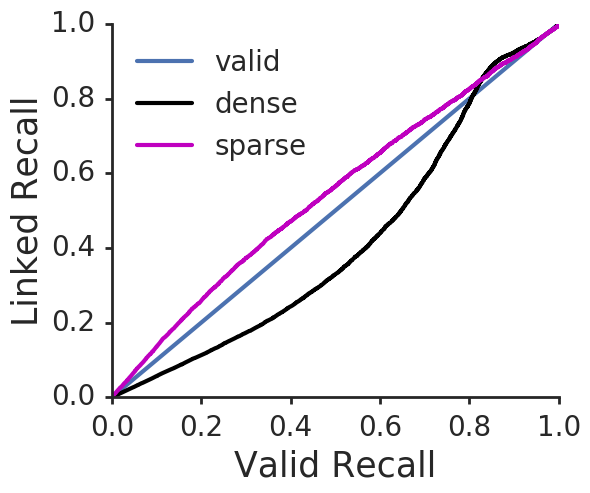

In [35]:
# Plot recall vs. recall based on the validation data
#
sns.set_style("white", {"xtick.major.size": "5", "ytick.major.size": "5",'axes.linewidth': 2})

fig, ax = plt.subplots(figsize=(6,5))

ax.plot(rec_v,rec_v,label='valid',linewidth=3)
ax.plot(rec_v,rec_hc,'k',label='dense',linewidth=3)
ax.plot(rec_v,rec_lc, 'm',label='sparse',linewidth=3)

plt.xlabel('Valid Recall',size=25)
plt.ylabel('Linked Recall',size=25)
ax = plt.gca()
ax.tick_params(width=2,labelsize=20)
plt.tight_layout()
sns.despine()

plt.legend(loc=2,fontsize=20)

sns.despine()

plt.savefig('./figure5b.pdf')

# Figure 5c

Plot the confluence of recall & precision across the three networks

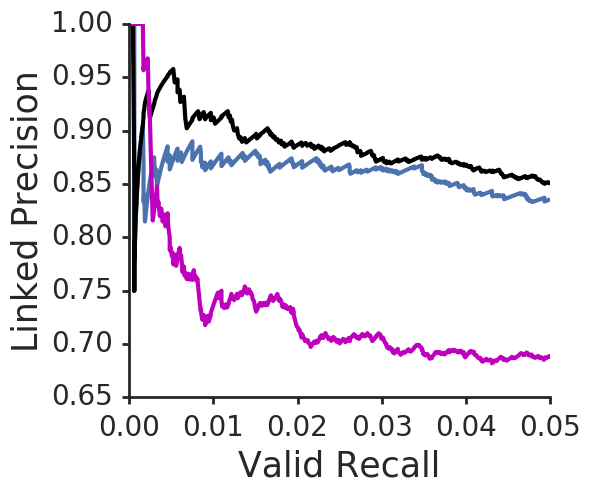

In [37]:
fig, ax = plt.subplots(figsize=(6,5))

plt.plot(rec_v,pre_v,linewidth=3)
plt.plot(rec_v,pre_hc,'k',linewidth=3)
plt.plot(rec_v,pre_lc,'m',linewidth=3)

plt.ylim([0.65, 1])
plt.xlim([0, 0.05])

plt.xlabel('Valid Recall',size=25)
plt.ylabel('Linked Precision',size=25)
ax = plt.gca()
ax.tick_params(width=2,labelsize=20)
plt.tight_layout()
sns.despine()

plt.savefig('./figure5c.pdf')

# Figure 5a
Plot histograms of the prediction tails for each of the three networks in order illustrtate the potential to predict the underlyiung sparsity and thus the proper threshold

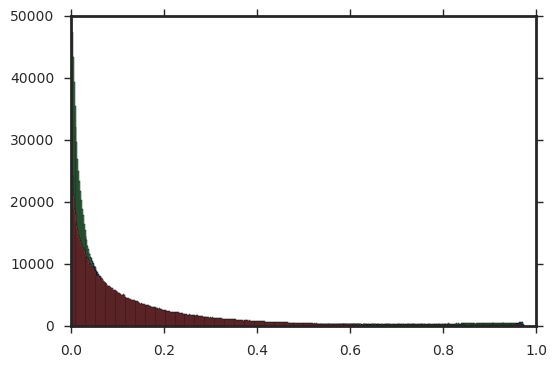

In [38]:
x = plt.hist(pred_all_RCNNPC_val,500)
y = plt.hist(pred_all_RCNNPC_hc,500)
z = plt.hist(pred_all_RCNNPC_lc,500)

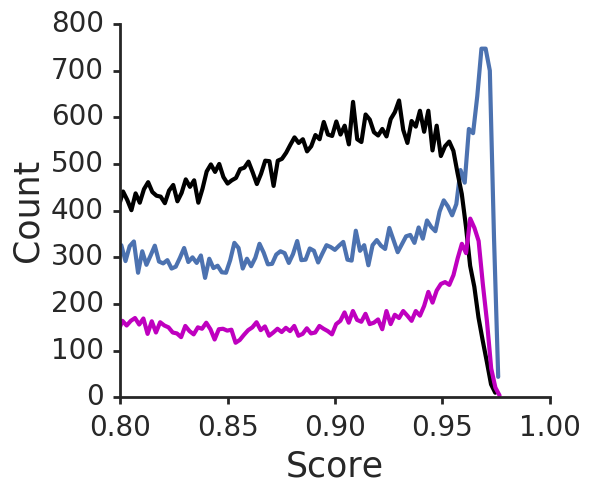

In [39]:
fig, ax = plt.subplots(figsize=(6,5))

plt.plot(x[1][1:],x[0],linewidth=3)
plt.plot(y[1][1:],y[0],'k',linewidth=3)
plt.plot(z[1][1:],z[0],'m',linewidth=3)
plt.ylim([0,800])
plt.xlim([0.8,1])

plt.xlabel('Score',size=25)
plt.ylabel('Count',size=25)
ax = plt.gca()
ax.tick_params(width=2,labelsize=20)
plt.tight_layout()
sns.despine()

plt.savefig('./figure5a.pdf')

plt.show()